In [1]:
import csv
import tensorflow as tf
import numpy as np
import os
import re
import random
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 25000 #25000 default
embedding_dim = 1
max_length = 20 #num of words; sentences padded with 0s if smaller
trunc_type='post' #truncate at the end
padding_type='post' #padding at the end
oov_tok = "<OOV>"
training_portion = .99  #80% training 20 testing

In [3]:
#stopwords = sanitisation that may be used
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))


153


# Cut text and music (by measure end ';'  )

In [4]:
sep_sent = '\.|!|\?|\.\.\.|…|;' #separate by punctuation or num of words
sep_phrases = '\.|!|\?|\.\.\.|…|,|:|;|-|—|"|\'|&'
sep_number = 20

In [5]:
def get_sentences(text, separator, max_len=120):
    sentences = []
    if isinstance(separator, int):
        #words = [*filter(lambda word: word not in stopwords, re.split('[^a-zа-я]+', text.lower()))] #uncomment to sanitise text
        words = re.split('[^a-zа-я0-9]+', text.lower())
        for i in range(0, len(words), separator):
            sentences.append(' '.join(words[i:i + separator]))
    else:
        for sent in re.split(separator, text.lower()):
            sent=list(re.split('[^a-zа-я0-9]+', sent ))
            if len(sent)<=max_len:
                sentences.append(sent)
    return sentences

In [54]:
func = lambda text: get_sentences(text, sep_sent, max_len=120)
file='testing.txt'
with open(file,'r',encoding='utf-8',errors='ignore') as f:
    patts=func(f.read())
print(patts)

[['sing111', 'o', 'goddess', 'the', 'anger', 'of', 'achilles', 'son', 'of', 'peleus', 'that', 'brought', 'countless', 'ills', 'upon', 'the', 'achaeans'], ['', 'many', 'a', 'brave', 'soul'], ['', 'did', 'it', 'send', 'hurrying'], ['', 'down', 'to', 'hades', 'and', 'many', 'a', 'hero', 'did', 'it', 'yield', 'a', 'prey', 'to', 'dogs', 'and', 'vultures', 'for', 'so', 'were', 'the', 'counsels', 'of', 'zeus', 'fulfilled', 'from', 'the', 'day', 'on', 'which', 'the', 'son', 'of', 'atreus', 'king', 'of', 'men', 'and', 'great', 'achilles', 'first', 'fell', 'out', 'with', 'one', 'another'], ['', 'and', 'which', 'of', 'the', 'gods', 'was', 'it', 'that', 'set', 'them', 'on', 'to', 'quarrel'], ['', 'it', 'was', 'the', 'son', 'of', 'zeus']]


In [35]:
with open(file,'r',encoding='utf-8',errors='ignore') as f:
    text_sample = f.read()
    print(file)
    print(text_sample)
    

testing.txt
Sing111, O goddess, the anger of Achilles son of Peleus, that brought
countless ills upon the Achaeans. Many a brave soul; did it send hurrying;
down to Hades, and many a hero did it yield a prey to dogs and vultures,
for so were the counsels of Zeus fulfilled from the day on which the
son of Atreus, king of men, and great Achilles, first fell out with
one another. 

And which of the gods was it that set them on to quarrel? It was the
son of Zeus


In [6]:
def walk_fs(folder):
    for label in os.listdir(folder):
        p = os.path.join(folder, label)
        if os.path.isdir(p):
            for file in os.listdir(p):
                file_path = os.path.join(p, file)
                with open(file_path, 'r',  encoding='utf-8', errors='ignore') as f:
                    yield label, file, f.read()

In [7]:
def get_labels_and_sentences(folder, get_patterns):
    labels = []
    sentences = []

    for label, _, text in walk_fs(folder):
        for sentence in get_patterns(text):
            labels.append(label)
            sentences.append(sentence)
    ls_list = list(zip(labels, sentences))
    random.shuffle(ls_list)
    return zip(*ls_list)

In [8]:
# Literature
separator = sep_number
func = lambda text: get_sentences(text, separator, max_len=20)
train_labels, train_sentences = get_labels_and_sentences('literature/train_texts', func)
predict_labels, predict_sentences = get_labels_and_sentences('literature/train_texts', func)

In [79]:
# Music
separator = sep_sent #separate by measures or number of chords
func = lambda text: get_sentences(text, separator, max_len=20)
train_labels, train_sentences = get_labels_and_sentences('music/train_texts_canada', func)
predict_labels, predict_sentences = get_labels_and_sentences('music/train_texts_canada', func)

In [53]:
# Both
separator = sep_number #
func = lambda text: get_sentences(text, separator, max_len=20)
train_labels, train_sentences = get_labels_and_sentences('both_modalities/train_both', func)
predict_labels, predict_sentences = get_labels_and_sentences('both_modalities/train_both', func)

# End of cut ^^^

In [121]:
def get_sentences(text, max_len=120):
    sentences = []
    #words = [*filter(lambda word: word not in stopwords, re.split('[^a-zа-я]+', text.lower()))] #uncomment to sanitise text
    words = re.split('[^a-zа-я]+', text.lower())
    for i in range(0, len(words), max_len):
        sentences.append(' '.join(words[i:i + max_len]))
    return sentences

In [122]:
def get_music_seqs(text, max_len):
    chords = []
    for measure in json.loads(text):
        chords.extend(measure)
    parts = []
    for i in range(0, len(chords), max_len):
        parts.append(' '.join(chords[i:i + max_len]))
    return parts

In [123]:
def walk_fs(folder):
    for label in os.listdir(folder):
        p = os.path.join(folder, label)
        if os.path.isdir(p):
            for file in os.listdir(p):
                file_path = os.path.join(p, file)
                with open(file_path, 'r',  encoding='utf-8', errors='ignore') as f:
                    yield label, file, f.read()

In [124]:
def get_labels_and_sentences(folder, get_patterns):
    labels = []
    sentences = []

    for label, _, text in walk_fs(folder):
        for sentence in get_patterns(text):
            labels.append(label)
            sentences.append(sentence)
    ls_list = list(zip(labels, sentences))
    random.shuffle(ls_list)
    return zip(*ls_list)

In [20]:
# literature
func = lambda text: get_sentences(text, max_len=120)
train_labels, train_sentences = get_labels_and_sentences('literature/train_texts', func)
predict_labels, predict_sentences = get_labels_and_sentences('literature/train_texts', func)

In [37]:
# music
func = lambda text: get_sentences(text, max_len=120)
train_labels, train_sentences = get_labels_and_sentences('music/train_txt', func)
predict_labels, predict_sentences = get_labels_and_sentences('music/train_txt', func)

In [11]:
# music
func = lambda text: get_sentences(text, max_len=100)
train_labels, train_sentences = get_labels_and_sentences('both_modalities/train_both_modalities', func)
predict_labels, predict_sentences = get_labels_and_sentences('both_modalities/train_both_modalities', func)

In [125]:
# music
func = lambda text: get_sentences(text, max_len=100)
train_labels, train_sentences = get_labels_and_sentences('music/train_json', func)
predict_labels, predict_sentences = get_labels_and_sentences('music/train_json', func)

# Tokenisation

In [9]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
#print(word_index)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print(train_padded[0].shape)
print(type(train_padded[0]))
btext= train_padded[0] #for testing prediction below
print(len(train_sequences[0]))
print(len(train_padded[0]))
print('train_sequences[0]=', train_sequences[0])
print('\n')
print('train_padded[0]=', train_padded[0])

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

(20,)
<class 'numpy.ndarray'>
20
20
train_sequences[0]= [72, 1915, 16, 40, 6, 72, 3540, 16, 25, 5, 360, 25, 5, 4015, 14, 201, 13, 1072, 44, 16]


train_padded[0]= [  72 1915   16   40    6   72 3540   16   25    5  360   25    5 4015
   14  201   13 1072   44   16]
20
20
20
20


In [10]:
validation_sequences = tokenizer.texts_to_sequences(predict_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)


16083
(16083, 20)


In [11]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels + predict_labels)
label_index = label_tokenizer.word_index
print(label_index)
print(len(label_index))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(predict_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[10])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)


{'homer': 1, 'dickens': 2, 'shakespeare': 3, 'joyce': 4, 'wscott': 5, 'chaucer': 6}
6
[3]
[4]
[6]
(16083, 1)
[6]
[1]
[1]
(16083, 1)


# ANN Architecture

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,\
Dropout, Activation, Flatten, Conv1D, MaxPooling1D,\
GlobalAveragePooling1D, Embedding, RNN, SimpleRNN

In [14]:
#RNN #the model used in experiments
num_of_output_neurons = len(label_index)+1 #n+1 classes!!!!!!!!!!!!!!!!

model = Sequential()
# model.add(tensorflow.keras.Input(shape=(250, 250, 3)))
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True, input_length=max_length))
# model.add(GlobalAveragePooling1D())
model.add(SimpleRNN( 2048, activation='relu',return_sequences=True)) #1024 def
model.add(Dropout(0.2)) #added option
model.add(Flatten())
# model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_of_output_neurons, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 1)             25000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 2048)          4198400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 2048)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40960)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               4096100   
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 8,320,207
Trainable params: 8,320,207
Non-trainable params: 0
____________________________________________

In [116]:
#RNN with 2 layers and dropout
num_of_output_neurons = len(label_index)+1 #n+1 classes!!!!!!!!!!!!!!!!

model = Sequential()
# model.add(tensorflow.keras.Input(shape=(250, 250, 3)))
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True, input_length=max_length))
# model.add(GlobalAveragePooling1D())
model.add(SimpleRNN( 4096, activation='relu',return_sequences=True)) #1024 def
model.add(Dropout(0.2))
model.add(SimpleRNN( 512, activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
# model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_of_output_neurons, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 1)             25000     
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 20, 4096)          16785408  
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 4096)          0         
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 20, 512)           2359808   
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)              

# Training the ANN

In [87]:
num_epochs = 20
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 15128 samples, validate on 15128 samples
Epoch 1/20
15128/15128 - 9s - loss: 0.9735 - accuracy: 0.5818 - val_loss: 0.6290 - val_accuracy: 0.7649
Epoch 2/20
15128/15128 - 7s - loss: 0.4761 - accuracy: 0.8267 - val_loss: 0.2817 - val_accuracy: 0.9034
Epoch 3/20
15128/15128 - 7s - loss: 0.2737 - accuracy: 0.9005 - val_loss: 0.1914 - val_accuracy: 0.9295
Epoch 4/20
15128/15128 - 7s - loss: 0.1841 - accuracy: 0.9325 - val_loss: 0.1221 - val_accuracy: 0.9569
Epoch 5/20
15128/15128 - 7s - loss: 0.1411 - accuracy: 0.9499 - val_loss: 0.0847 - val_accuracy: 0.9709
Epoch 6/20
15128/15128 - 7s - loss: 0.1057 - accuracy: 0.9625 - val_loss: 0.0696 - val_accuracy: 0.9752
Epoch 7/20
15128/15128 - 7s - loss: 0.0894 - accuracy: 0.9683 - val_loss: 0.0921 - val_accuracy: 0.9688
Epoch 8/20
15128/15128 - 7s - loss: 0.0748 - accuracy: 0.9730 - val_loss: 0.0469 - val_accuracy: 0.9831
Epoch 9/20
15128/15128 - 7s - loss: 0.0641 - accuracy: 0.9771 - val_loss: 0.0445 - val_accuracy: 0.9843
Epoch 10/20
15

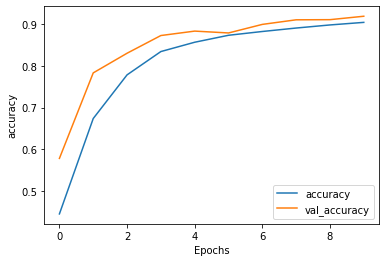

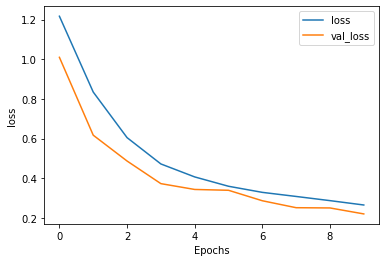

In [19]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [41]:
"""Text decoder"""
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [146]:
#btext is taken from Tokenizer code above, it's a coded text passage
print(type(btext))
print(btext)
print(btext.shape)
print(decode_sentence(btext))

<class 'numpy.ndarray'>
[4368   35   31    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   

## Categorisation of novel stimuli

In [16]:
def get_attention_words(text, max_len):
    all_words = re.split('\W+', text)
    result = []
    for i in range(0, len(all_words), max_len):
        result.append(all_words[i:i + max_len])
    return result

def walk_dir(folder):
    result = []
    for label in os.listdir(folder):
        p = os.path.join(folder, label)
        if os.path.isdir(p):
            for filename in os.listdir(p):
                file = os.path.join(p, filename)
                with open(file, 'r',  encoding='utf-8', errors='ignore') as f:
                    result.append((label, filename, f.read()))
    return result

In [16]:
print(get_attention_words(text_sample, 10))

NameError: name 'text_sample' is not defined

In [17]:
def get_scores(predictions):
    scores = {}
    for prediction in predictions:
        winner_idx = np.argmax(prediction)
        scores[winner_idx] = scores.get(winner_idx, 0) + 1
    return scores

In [132]:
folder = 'literature/predict_texts'
#folder = 'music/predict_texts'
# folder = 'music/predict_texts_60'
folder = 'music/predict_json_60'
# folder = 'both_modalities/predict_both_modalities'
count_correct = 0
count_all = 0
for name, filename, content in walk_dir(folder):
    sentences = get_attention_words(content, max_length)
    tokenized_sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(tokenized_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    predictions = model.predict(padded)
    print('predictions=',predictions)
    scores = get_scores(predictions)
    names = {idx: name for name, idx in label_index.items()}
    sorted_score = sorted(scores.items(), key=lambda x: -x[1])
    print('sorted_score=',sorted_score)
    print(name, filename)
    for label, score in sorted_score:
        print(f'{names[label]} -> {score}')
    winner_name = names[sorted_score[0][0]]
    count_all += 1
    count_correct += name == winner_name
    print('CORRECT' if name == winner_name else 'WRONG')
    print()
print(f'TOTAL: correct {count_correct} / {count_all}')

predictions= [[0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 

predictions= [[0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 

predictions= [[0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 

predictions= [[7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.629874

predictions= [[0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 

 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]]
sorted_score= [(4, 51)]
bthvn Piano Sonata n18 The Hunt_1.json
bthvn -> 51
CORRECT

predictions= [[0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.162987

predictions= [[0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 

predictions= [[0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 

predictions= [[0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 

predictions= [[0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 

predictions= [[7.88910256e-04 1.15159281e-01 1.62987456e-01 2.08868816e-01
  5.12195528e-01]
 [7.88910256e-04 1.15159281e-01 1.62987456e-01 2.08868816e-01
  5.12195528e-01]
 [7.88910256e-04 1.15159281e-01 1.62987456e-01 2.08868816e-01
  5.12195528e-01]
 ...
 [7.88910256e-04 1.15159281e-01 1.62987456e-01 2.08868816e-01
  5.12195528e-01]
 [7.88910256e-04 1.15159281e-01 1.62987456e-01 2.08868816e-01
  5.12195528e-01]
 [3.97824449e-04 1.04401916e-01 1.29384995e-01 1.90725863e-01
  5.75089395e-01]]
sorted_score= [(4, 376)]
mozart K331 Piano Sonata n11 .json
bthvn -> 376
WRONG

predictions= [[0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [0.00078891 0.11515928 0.16298746 0.20886882 0.5121955 ]
 [

predictions= [[7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.6298746e-01 2.0886882e-01 5.1219553e-01]
 [7.8891026e-04 1.1515928e-01 1.629874

## Normalised output

In [118]:
#NORMALISED OUTPUT
folder = 'literature/predict_texts'
count_correct = 0
count_all = 0
for name, filename, content in walk_dir(folder):
    sentences = get_attention_words(content, max_length)
    tokenized_sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(tokenized_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    predictions = model.predict(padded)
    scores = get_scores(predictions)
    scores_sum = sum(scores.values()) #sum all votes
#     print('scores sum=',scores_sum)
    names = {idx: name for name, idx in label_index.items()}
    print('names=',names)
    scores_normalised = {names[key]:0 for key,val in names.items()}
    print('scores_normalised1=', scores_normalised)
    scores_normalised = {names[idx]: np.around(score / scores_sum, decimals=2) for idx, score in scores.items()} #noramlise and round scores
    print('scores_normalised=', scores_normalised)
    print('scores_normalised.items()=', scores_normalised.items())
    sorted_norm = sorted(scores_normalised.items(), key=lambda x: -x[1])
#     print('sorted_norm=', sorted_norm)

    print(name, filename[:-4])
    for label, score in sorted_norm:
        print(f'{label} -> {score}')
    winner_name = sorted_norm[0][0]
    count_all += 1
    count_correct += name == winner_name
    print('CORRECT' if name == winner_name else 'WRONG')
    print()
print(f'TOTAL: correct {count_correct} / {count_all}')

names= {1: 'bthvn', 2: 'mozart', 3: 'chopin', 4: 'bach'}
scores_normalised1= {'bthvn': 0, 'mozart': 0, 'chopin': 0, 'bach': 0}
scores_normalised= {'bach': 1.0}
scores_normalised.items()= dict_items([('bach', 1.0)])
chaucer canterbury_tale1
bach -> 1.0
WRONG

names= {1: 'bthvn', 2: 'mozart', 3: 'chopin', 4: 'bach'}
scores_normalised1= {'bthvn': 0, 'mozart': 0, 'chopin': 0, 'bach': 0}
scores_normalised= {'bach': 1.0}
scores_normalised.items()= dict_items([('bach', 1.0)])
chaucer canterbury_tale2
bach -> 1.0
WRONG

names= {1: 'bthvn', 2: 'mozart', 3: 'chopin', 4: 'bach'}
scores_normalised1= {'bthvn': 0, 'mozart': 0, 'chopin': 0, 'bach': 0}
scores_normalised= {'bach': 1.0}
scores_normalised.items()= dict_items([('bach', 1.0)])
chaucer canterbury_tale3
bach -> 1.0
WRONG

names= {1: 'bthvn', 2: 'mozart', 3: 'chopin', 4: 'bach'}
scores_normalised1= {'bthvn': 0, 'mozart': 0, 'chopin': 0, 'bach': 0}
scores_normalised= {'bach': 1.0}
scores_normalised.items()= dict_items([('bach', 1.0)])
chaucer 

## CSV writer for final results

In [18]:
def write_csv_from_dicts(csv_file, lines):
    with open(csv_file, 'w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, delimiter=';', fieldnames=lines[0])
        writer.writeheader()
        for line in lines:
            writer.writerow(line)

In [88]:
#NORMALISED OUTPUT + CSV writer
# folder = 'literature/predict_texts_60'
folder = 'music/predict_texts_60'
# folder = 'music/predict_texts_bach'
# folder = 'music/predict_texts_notransNO'
# folder = 'both_modalities/predict_texts_60'
# folder = 'both_modalities/predict_both'
count_correct = 0
count_all = 0
csv_lines=[] #initialise the list of dicts to output into CSV file
for name, filename, content in walk_dir(folder):
    sentences = get_attention_words(content, max_length)
    tokenized_sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(tokenized_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    predictions = model.predict(padded)
    scores = get_scores(predictions)
    
#     print('scores=',scores)
    scores_sum = sum(scores.values()) #sum all votes
#     print('scores sum=',scores_sum)
    names = {idx: name for name, idx in label_index.items()}
#     print('names=',names)
    scores_with_names = {names[key]:val for key,val in scores.items()}
#     print('scores_with_names', scores_with_names)
    
    empty_dict = {names[key]:0 for key,val in names.items()} 
    scores_normalised = empty_dict #initialise the scores dict
#     print('scores_normalised1=', scores_normalised)
    for key, val in scores_with_names.items(): #fill the scores dict
        scores_normalised[key] = np.around(val / scores_sum, decimals=2)
       
    
    
#     print('scores_normalised1=', scores_normalised)
#     scores_normalised = {names[idx]: np.around(score / scores_sum, decimals=2)  for idx, score in scores.items()} #noramlise and round scores
#     print('scores_normalised=', scores_normalised)
#     print('scores_normalised.items()=', scores_normalised.items())
    sorted_norm = sorted(scores_normalised.items(), key=lambda x: -x[1])
#     print('sorted_norm=', sorted_norm)

    print(name, filename[:-4])
    for label, score in sorted_norm:
        print(f'{label} -> {score}')
    winner_name = sorted_norm[0][0]
    count_all += 1
    count_correct += name == winner_name
    
    csv_dict = {'author':name, 'file':filename[:-4]} #CSV dict begins with author and text cols
    csv_dict1 = scores_normalised #CSV dict continues with scores columns
    csv_dict.update(csv_dict1)
    csv_dict['correct']= name == winner_name #CSV dict finishes with True/False column
    csv_lines.append(csv_dict)
    print('CORRECT' if name == winner_name else 'WRONG')
    print()
print(f'TOTAL: correct {count_correct} / {count_all}')



bach WTCII09A
bach -> 0.91
bthvn -> 0.05
mozart -> 0.03
chopin -> 0.02
CORRECT

bach Wtcii09b
bach -> 0.89
bthvn -> 0.11
mozart -> 0
chopin -> 0
CORRECT

bach Wtcii10a
bach -> 0.71
bthvn -> 0.11
mozart -> 0.09
chopin -> 0.09
CORRECT

bach Wtcii10b
bach -> 0.77
mozart -> 0.11
bthvn -> 0.08
chopin -> 0.04
CORRECT

bach Wtcii11a
bach -> 0.82
bthvn -> 0.11
chopin -> 0.07
mozart -> 0
CORRECT

bach Wtcii11b
bach -> 0.9
bthvn -> 0.1
mozart -> 0
chopin -> 0
CORRECT

bach WTCII12A
bach -> 0.84
bthvn -> 0.1
mozart -> 0.04
chopin -> 0.02
CORRECT

bach Wtcii12b
bach -> 0.76
bthvn -> 0.12
mozart -> 0.06
chopin -> 0.06
CORRECT

bach WTCII13A
bach -> 0.52
bthvn -> 0.29
mozart -> 0.19
chopin -> 0
CORRECT

bach Wtcii13b
bach -> 0.83
chopin -> 0.11
bthvn -> 0.03
mozart -> 0.03
CORRECT

bach WTCII21A
bach -> 0.82
bthvn -> 0.11
chopin -> 0.05
mozart -> 0.02
CORRECT

bach Wtcii21b
bach -> 0.86
bthvn -> 0.11
mozart -> 0.04
chopin -> 0
CORRECT

bach WTCII22A
bach -> 1.0
bthvn -> 0
mozart -> 0
chopin -> 0
COR

In [63]:
""" WRITE CSV !!!!!!!!!!!!!!!! """#####
#######################################
write_csv_from_dicts('ANN_RNNw16dims_both1_101o120.csv', csv_lines)

In [ ]:
write_csv_from_dicts('testing2020/finetuning results/exp5_letters/mus_letters_Freq_30o60.csv', result5)

In [ ]:
def cat_patterns(folder, separator): #categorise with LETTER primitives, Freq with prebuilt label dict
    return cat2(folder, lambda text: get_literature_patterns(text, separator, split_by_letters=True))

In [0]:
def get_windows(full_text, win_len, step):
    for i in range(0, len(full_text), step):
        yield full_text[i:i + win_len]

In [0]:
folder = '/tmp/literature/predict_texts'

In [0]:
from collections import Counter

In [0]:
for label, file, text in walk_fs(folder):
    counter = Counter()
    for sentences in get_windows(text, win_len=50, step=10):
        print('len(sentences)=',len(sentences))
        tokenized_sequences = tokenizer.texts_to_sequences(sentences)
        padded = pad_sequences(tokenized_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
        predictions = model.predict(padded)
        #print(predictions)
        #print(label_index)
        for prediction in predictions:
            winning_index = np.argmax(prediction)
            # print('winning_index=',winning_index)
            for name, index in label_index.items():
                if index==winning_index:
                    print(name, 'prob=', prediction[index])

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/tmp/literature/predict_texts'

In [58]:
scores_dict={}
for prediction in predictions:
    i=1
    for key in label_index.keys():
        scores_dict[key] = prediction[i]
        #print( 'author {} (prob= {})'.format(key, prediction[i]) )
        i+=1
    print('\n')
    #print((scores_dict))
    scores_list = [(k,v) for k,v in scores_dict.items()]
    sorted_scores_list = sorted(scores_list, key=lambda x: -x[1]) #referesh tute on dict vals sorting at bottom page
    print(scores_list,'\n')
    print('sorted_scores_list=', sorted_scores_list)
    for pair in sorted_scores_list:
        print('author {} (prob = {})'.format(pair[0], pair[1])) #HOW TO ROUND?????????????????????
    print('--------------------------')

    



[('homer', 0.00541953), ('dickens', 0.0013650135), ('shakespeare', 0.005370454), ('joyce', 0.000120007426), ('wscott', 0.98772496), ('chaucer', 1.0140333e-08)] 

sorted_scores_list= [('wscott', 0.98772496), ('homer', 0.00541953), ('shakespeare', 0.005370454), ('dickens', 0.0013650135), ('joyce', 0.000120007426), ('chaucer', 1.0140333e-08)]
author wscott (prob = 0.9877249598503113)
author homer (prob = 0.005419529974460602)
author shakespeare (prob = 0.005370453931391239)
author dickens (prob = 0.0013650135369971395)
author joyce (prob = 0.0001200074257212691)
author chaucer (prob = 1.014033301771633e-08)
--------------------------


[('homer', 0.81366706), ('dickens', 0.029611995), ('shakespeare', 1.9310919e-05), ('joyce', 0.15667017), ('wscott', 3.1502706e-05), ('chaucer', 5.9712846e-11)] 

sorted_scores_list= [('homer', 0.81366706), ('joyce', 0.15667017), ('dickens', 0.029611995), ('wscott', 3.1502706e-05), ('shakespeare', 1.9310919e-05), ('chaucer', 5.9712846e-11)]
author homer (p

--------------------------


[('homer', 0.0004888332), ('dickens', 0.19348384), ('shakespeare', 0.0002340373), ('joyce', 6.7829915e-06), ('wscott', 0.8057865), ('chaucer', 2.1304702e-10)] 

sorted_scores_list= [('wscott', 0.8057865), ('dickens', 0.19348384), ('homer', 0.0004888332), ('shakespeare', 0.0002340373), ('joyce', 6.7829915e-06), ('chaucer', 2.1304702e-10)]
author wscott (prob = 0.8057864904403687)
author dickens (prob = 0.1934838443994522)
author homer (prob = 0.0004888331750407815)
author shakespeare (prob = 0.00023403730301652104)
author joyce (prob = 6.78299147693906e-06)
author chaucer (prob = 2.1304702446656165e-10)
--------------------------


[('homer', 0.0026967234), ('dickens', 1.3911995e-07), ('shakespeare', 0.9964342), ('joyce', 3.2063403e-09), ('wscott', 0.00083542225), ('chaucer', 3.347582e-05)] 

sorted_scores_list= [('shakespeare', 0.9964342), ('homer', 0.0026967234), ('wscott', 0.00083542225), ('chaucer', 3.347582e-05), ('dickens', 1.3911995e-07), ('joyce', 3.

author joyce (prob = 0.0005260090692900121)
author chaucer (prob = 3.5200335979368447e-09)
--------------------------


[('homer', 4.034795e-11), ('dickens', 1.5804683e-21), ('shakespeare', 0.99988055), ('joyce', 5.601781e-18), ('wscott', 3.548839e-09), ('chaucer', 0.00011940872)] 

sorted_scores_list= [('shakespeare', 0.99988055), ('chaucer', 0.00011940872), ('wscott', 3.548839e-09), ('homer', 4.034795e-11), ('joyce', 5.601781e-18), ('dickens', 1.5804683e-21)]
author shakespeare (prob = 0.9998805522918701)
author chaucer (prob = 0.00011940872354898602)
author wscott (prob = 3.548839000444559e-09)
author homer (prob = 4.0347950674979316e-11)
author joyce (prob = 5.6017808455433295e-18)
author dickens (prob = 1.580468308569641e-21)
--------------------------


[('homer', 0.99817646), ('dickens', 6.779689e-07), ('shakespeare', 0.00021233995), ('joyce', 1.2917151e-06), ('wscott', 0.0016092582), ('chaucer', 4.239193e-10)] 

sorted_scores_list= [('homer', 0.99817646), ('wscott', 0.001609258